In [1]:
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, missing_data, correlation


importing Jupyter notebook from evaluation.ipynb


In [2]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 7)

In [3]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
#start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
#end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1679029200000 Until: 1680238800000


In [4]:
# Query Data Sensors
query = query_data(tangaras, start_timestamp, end_timestamp)
print(query)

SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0DD66') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0E752') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE1260A') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE94B1A') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE965F2') AND time >= 1679029200000ms AND time <= 1680238800000ms GROUP BY time(30s) fill(none); SELECT "name", last("pm25") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DEBD89A') AND time >= 1679029200000ms AND time 

In [5]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp)
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'PM25'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'PM25']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'PM25': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('float64')
    
    return df_sensors


In [6]:
# Data Frame Sensors
pm25_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
pm25_raw.head()

,DATETIME,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
0,2023-03-17T18:49:30-05:00,10.0,13.0,NaN,9.0,NaN,14.0,9.0,NaN,NaN,...,5.0,0.0,1.0,5.0,NaN,11.0,11.0,1.0,4.0,NaN
1,2023-03-17T18:50:00-05:00,10.0,13.0,NaN,9.0,NaN,14.0,9.0,NaN,4.0,...,5.0,0.0,1.0,5.0,NaN,10.0,12.0,0.0,4.0,NaN
2,2023-03-17T18:51:00-05:00,10.0,12.0,NaN,10.0,NaN,14.0,9.0,NaN,4.0,...,6.0,0.0,1.0,5.0,NaN,10.0,12.0,1.0,5.0,NaN
3,2023-03-17T18:51:30-05:00,10.0,12.0,NaN,10.0,NaN,13.0,9.0,NaN,4.0,...,NaN,0.0,1.0,5.0,NaN,11.0,12.0,0.0,3.0,NaN
4,2023-03-17T18:52:00-05:00,10.0,13.0,NaN,8.0,NaN,13.0,9.0,NaN,4.0,...,5.0,0.0,1.0,5.0,NaN,10.0,12.0,1.0,3.0,NaN


# Descriptive Statistics

In [7]:
# Describe Data
pm25_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,27537.000000,27066.000000,7384.000000,26889.000000,8035.000000,26887.000000,26595.000000,1090.000000,26758.000000,25374.000000,...,25781.000000,27407.000000,26121.000000,26177.000000,16471.000000,26939.000000,26773.000000,27272.000000,26978.000000,26368.000000
mean,8.802774,10.708527,10.815141,8.631671,10.730056,11.031577,8.557511,11.027523,48.120824,17.048790,...,14.104457,9.701025,9.578423,11.417504,15.978690,9.367089,10.357375,9.391757,11.843799,12.762856
std,6.288778,6.997494,6.898351,5.834453,6.809177,7.072546,5.791516,5.265161,218.485579,12.267974,...,12.127839,8.647964,7.288623,7.195781,12.697584,6.340421,6.926161,55.153417,10.501616,8.002437
min,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,2.000000,...,1.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,4.000000,5.000000,6.000000,4.000000,6.000000,5.000000,4.000000,8.000000,7.000000,10.000000,...,8.000000,3.000000,5.000000,7.000000,10.000000,5.000000,5.000000,5.000000,6.000000,8.000000
50%,7.000000,9.000000,10.000000,7.000000,9.000000,9.000000,7.000000,9.000000,10.000000,14.000000,...,12.000000,9.000000,7.000000,11.000000,13.000000,8.000000,9.000000,8.000000,10.000000,12.000000
75%,12.000000,15.000000,14.000000,12.000000,15.000000,15.000000,12.000000,14.000000,15.000000,20.000000,...,16.000000,14.000000,12.000000,14.000000,18.000000,13.000000,14.000000,11.000000,15.000000,15.000000
max,78.000000,147.000000,84.000000,139.000000,80.000000,139.000000,124.000000,36.000000,4305.000000,231.000000,...,594.000000,131.000000,100.000000,57.000000,746.000000,141.000000,246.000000,7424.000000,563.000000,205.000000


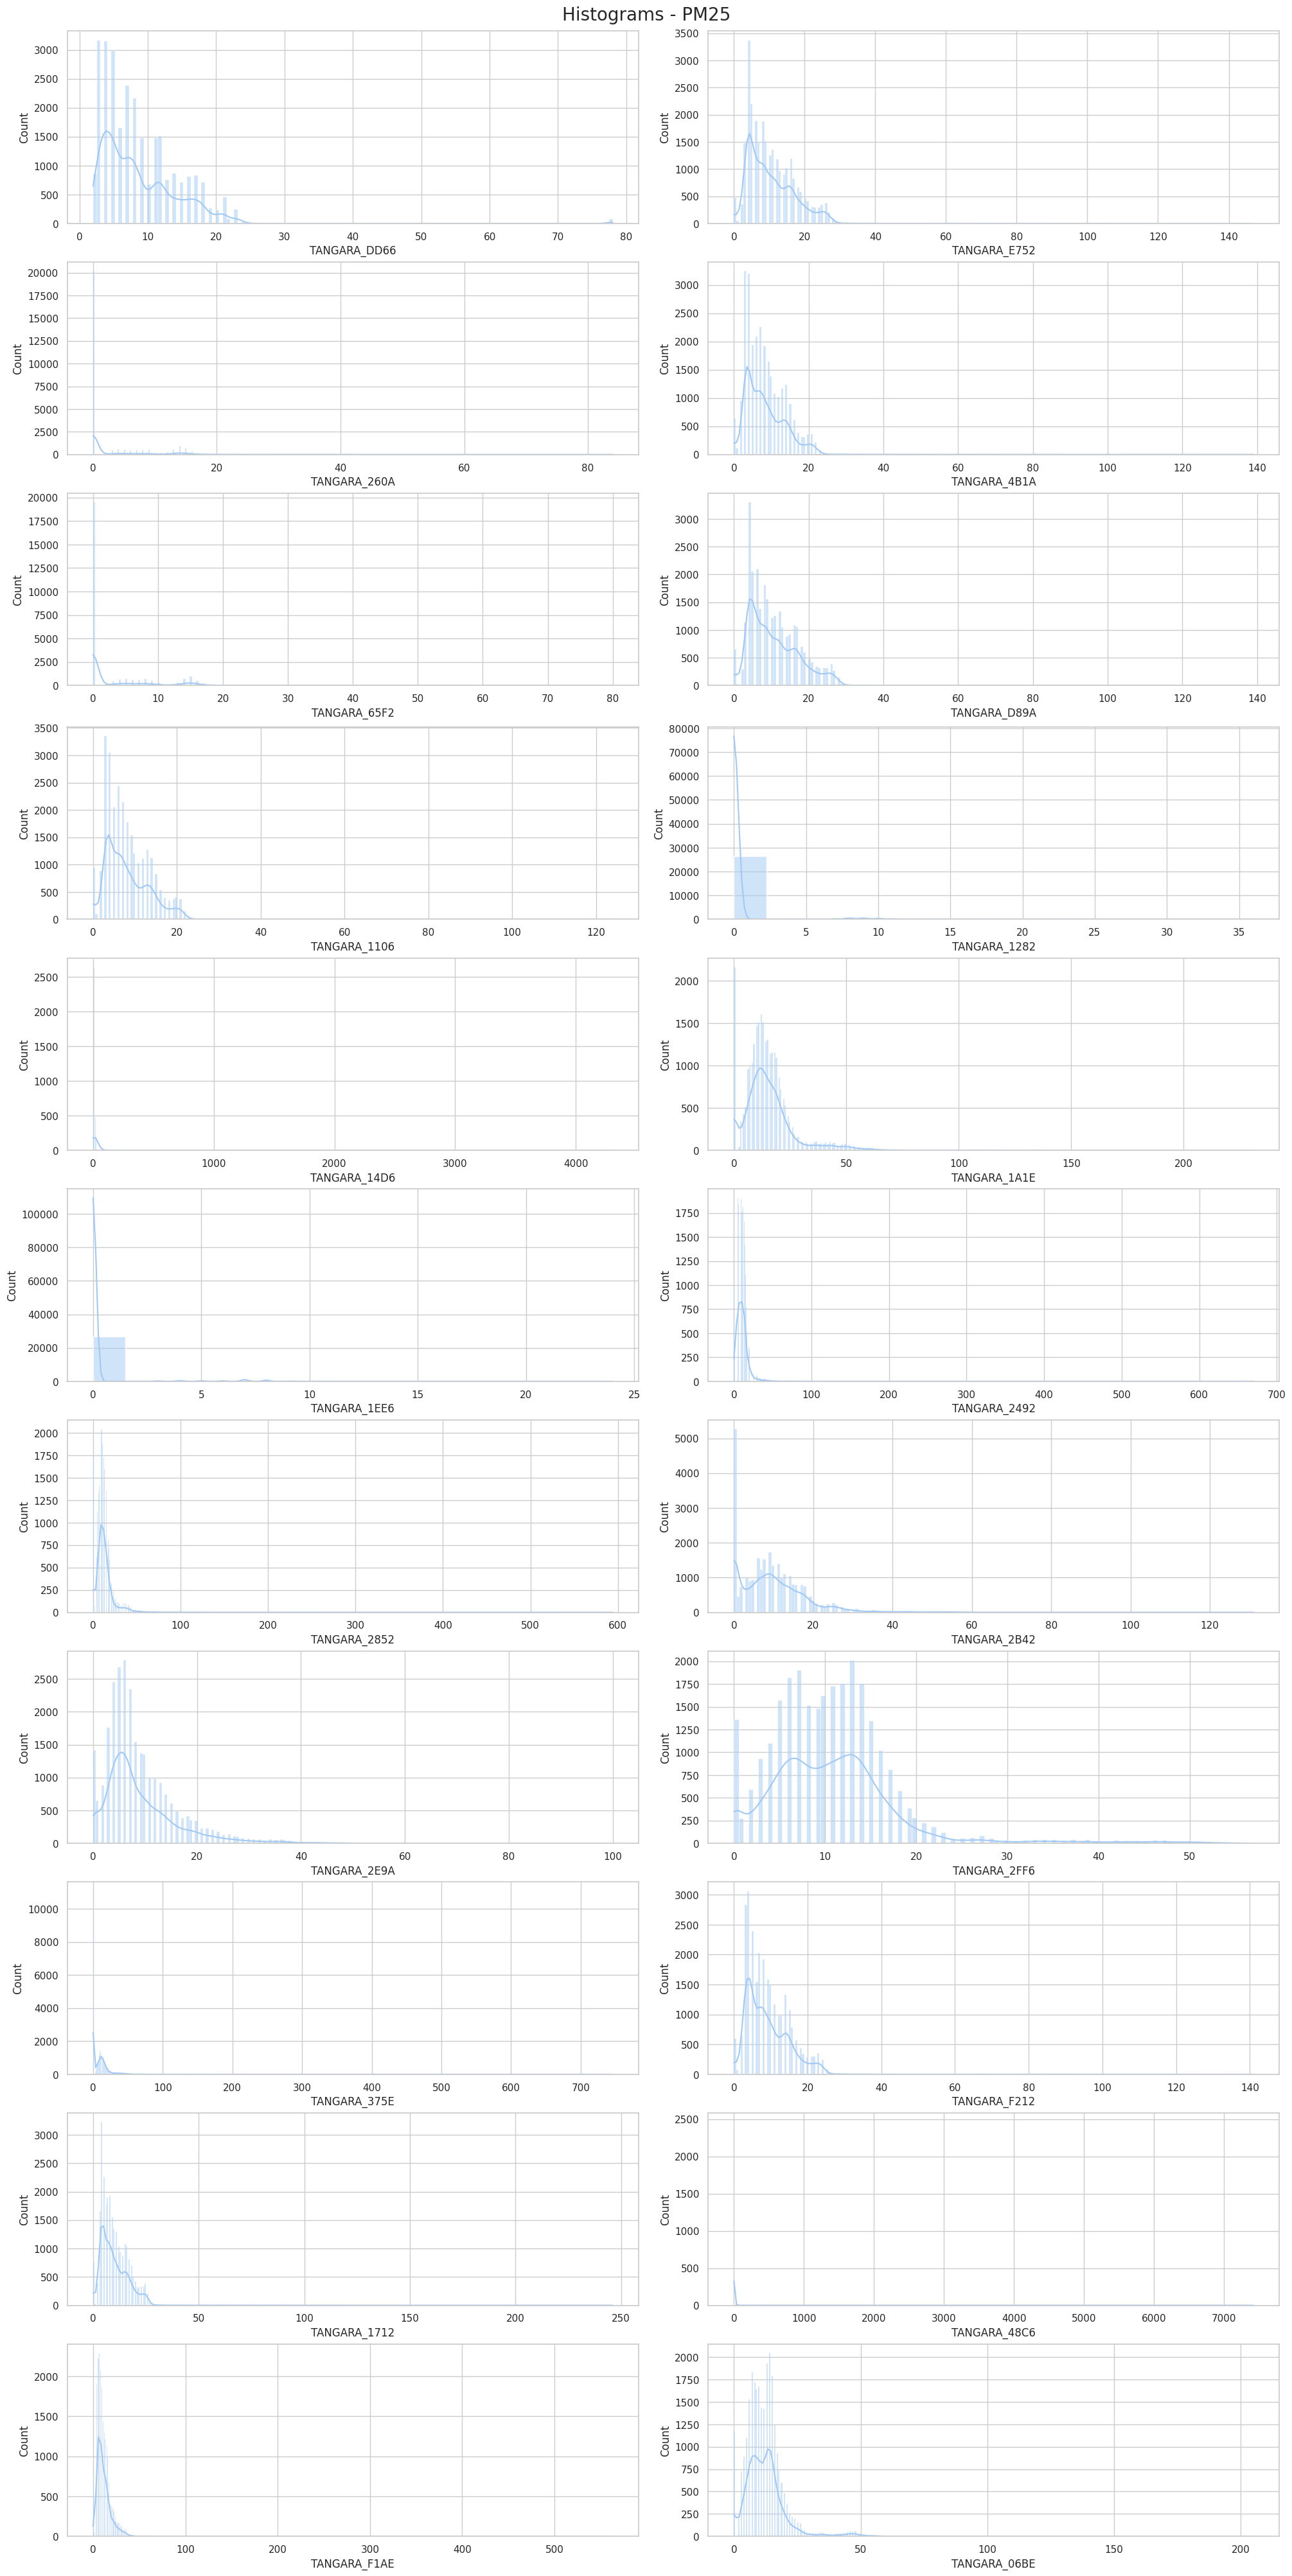

In [8]:
# Plot PM25 Histograms
histplots(pm25_raw)

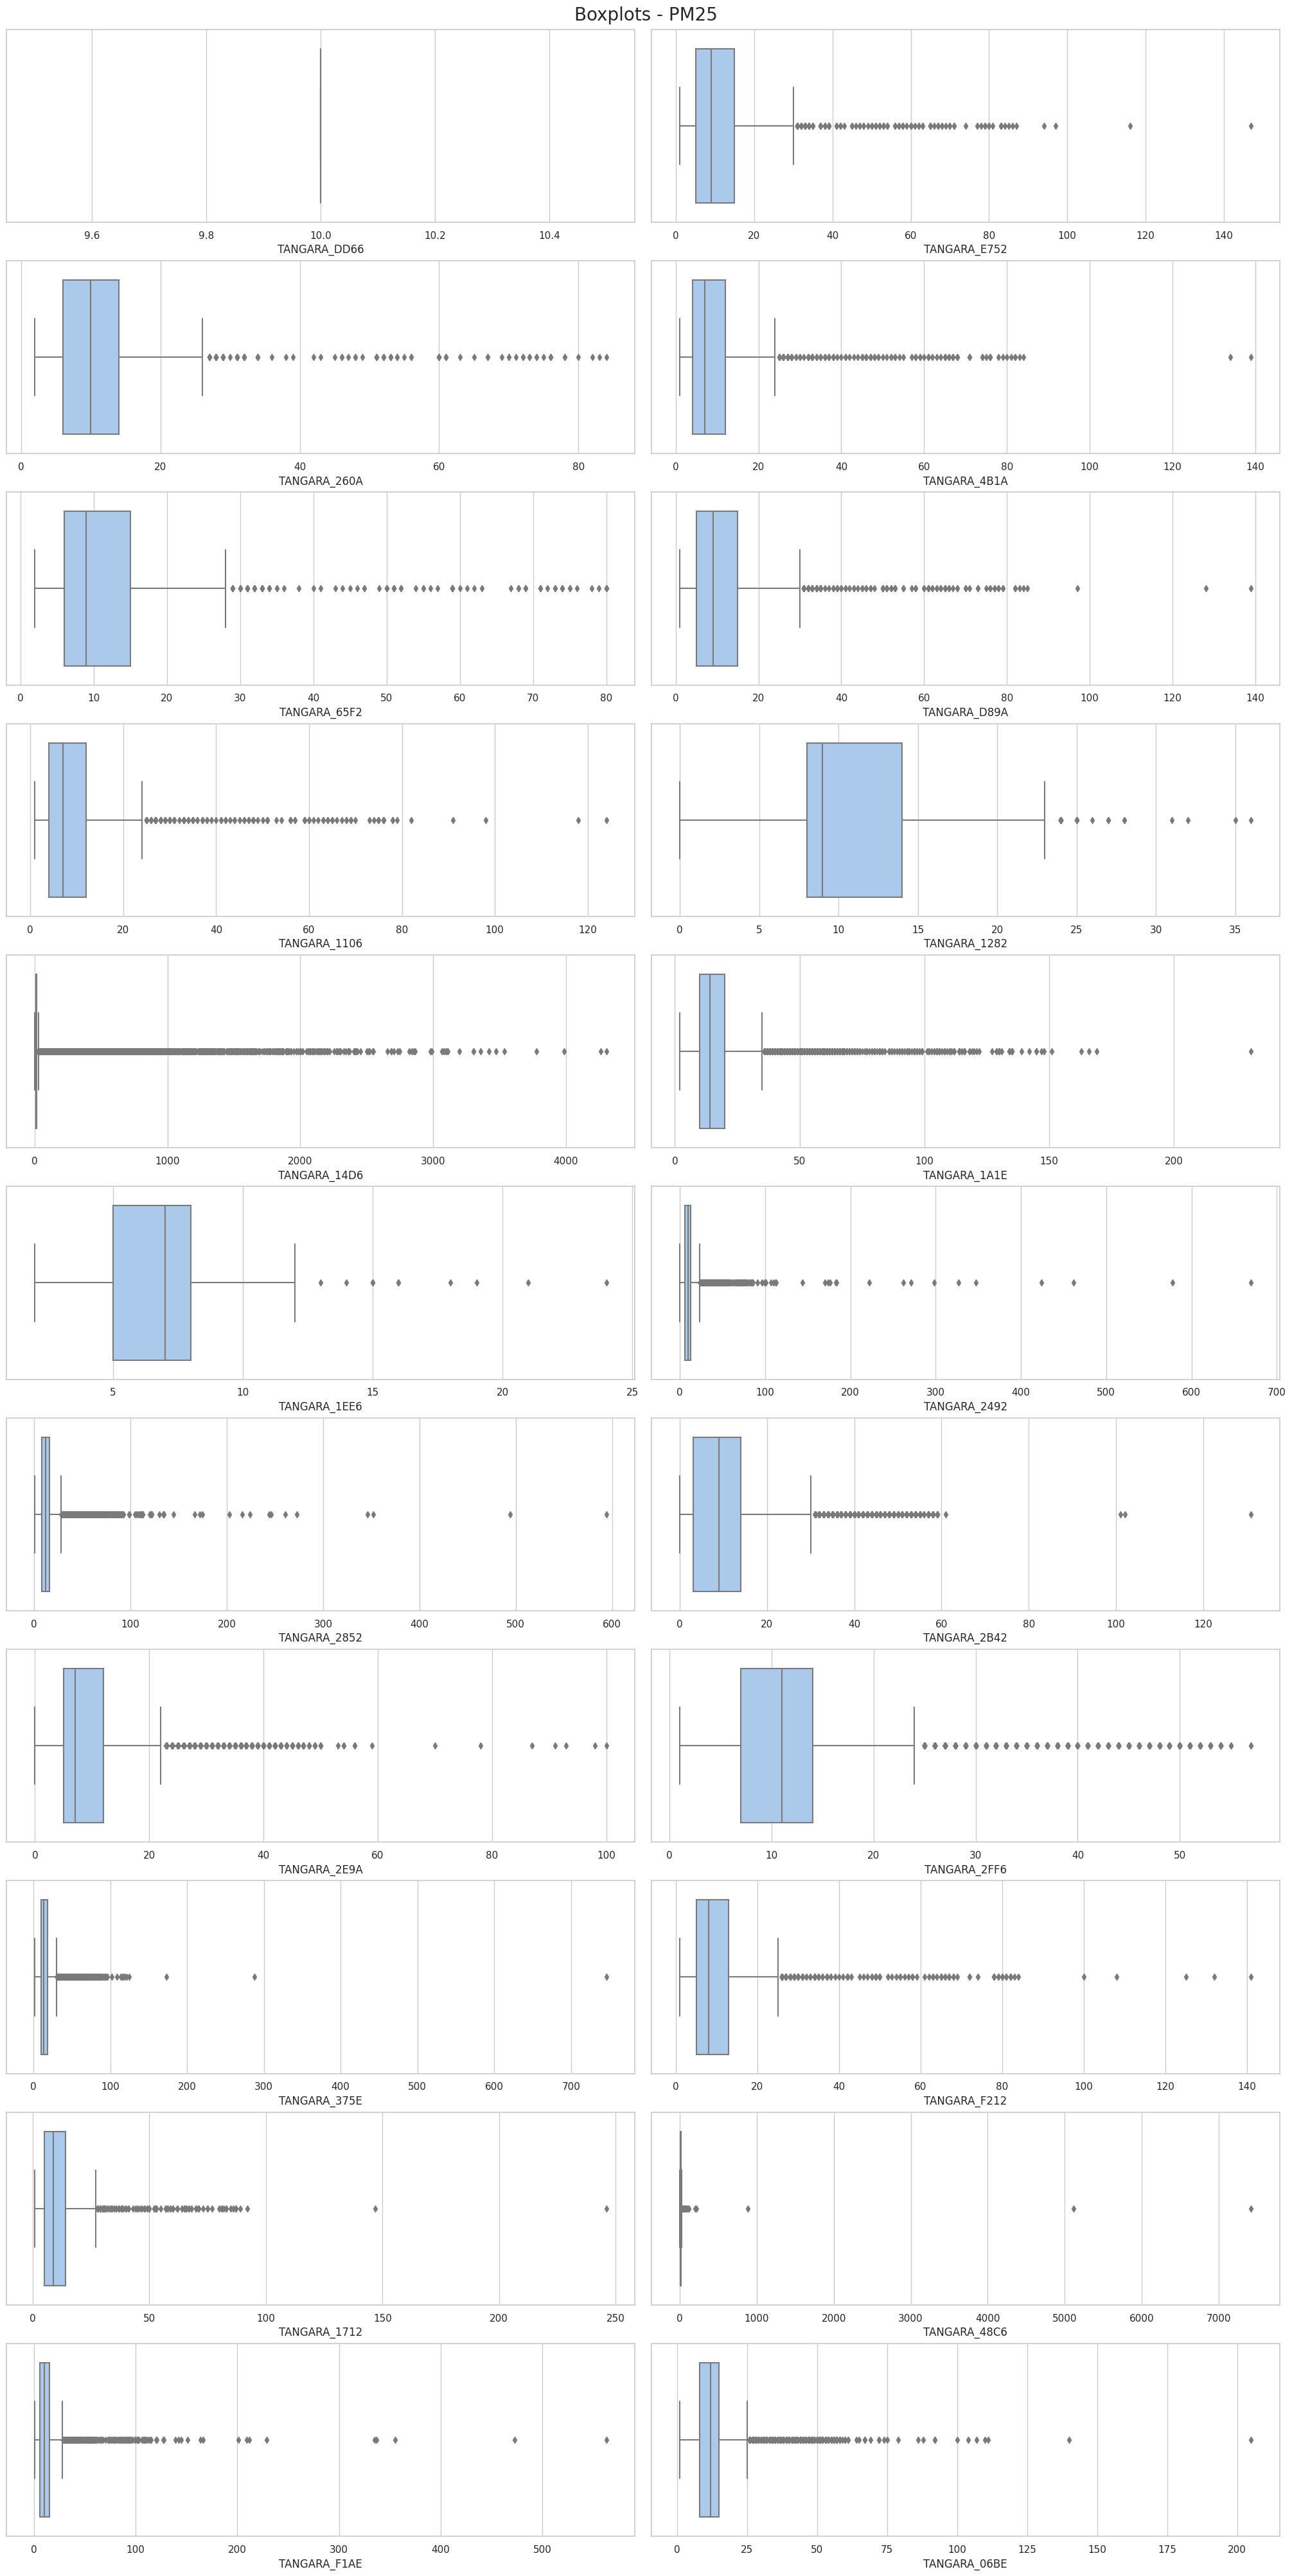

In [9]:
# Plot PM25 Boxplots
boxplots(pm25_raw)

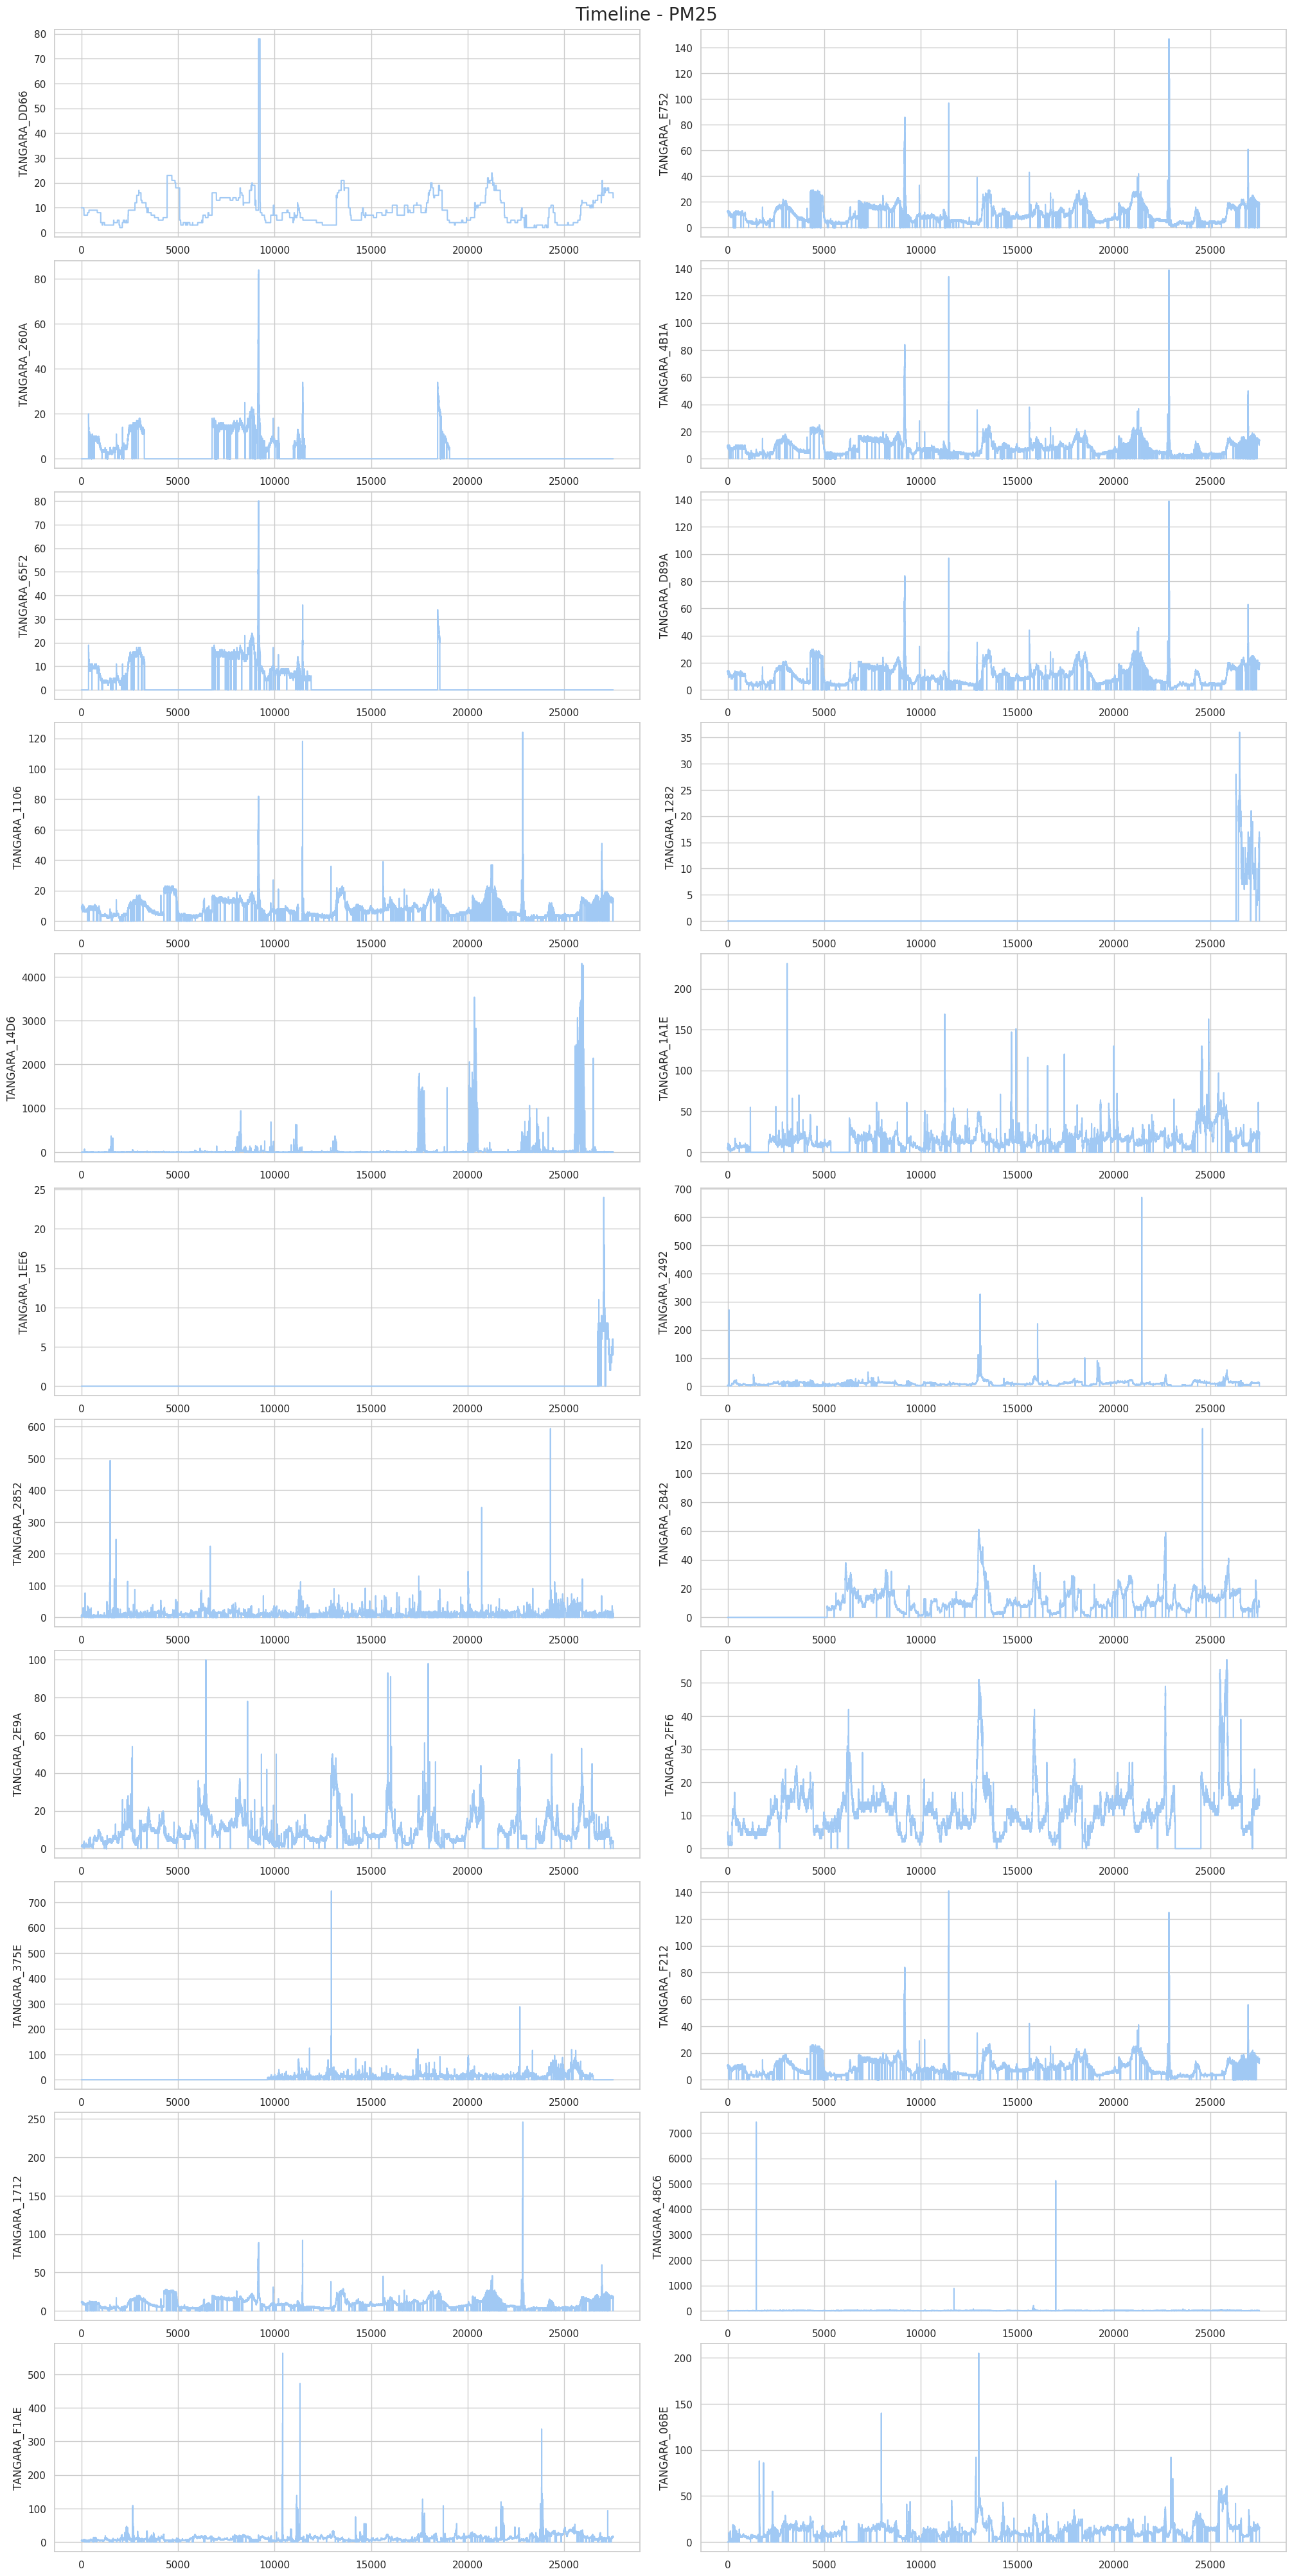

In [10]:
# Plot PM25 Lineplots
lineplots(pm25_raw)

In [11]:
# Missing Data Sensors
threshold = 85
to_be_checked = missing_data(pm25_raw, threshold)

print(f'Threshold: {threshold}%')
print(f'Total Sensors: {len(pm25_raw.columns[1:])}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked


Threshold: 85%
Total Sensors: 22
To Be Checked: 5


[{'ID': 'TANGARA_260A', 'Data': '27%', 'Missing': '73%'},
 {'ID': 'TANGARA_65F2', 'Data': '29%', 'Missing': '71%'},
 {'ID': 'TANGARA_1282', 'Data': '4%', 'Missing': '96%'},
 {'ID': 'TANGARA_1EE6', 'Data': '3%', 'Missing': '97%'},
 {'ID': 'TANGARA_375E', 'Data': '60%', 'Missing': '40%'}]

In [12]:
# Sensors to evaluate by Pearson correlation coefficient
sensors_to_evaluate = pm25_raw[['DATETIME', 'TANGARA_DD66', 'TANGARA_E752', 'TANGARA_4B1A', 'TANGARA_D89A', 'TANGARA_1106', 'TANGARA_F212', 'TANGARA_1712']]

# Pearson correlation coefficient
threshold = 0.85
to_be_checked = correlation(sensors_to_evaluate, 'TANGARA_4B1A', threshold)

# Correlation Sensors
print(f'Threshold: {threshold}')
print(f'Total Sensors: {len(sensors_to_evaluate.columns[1:])}')
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked


Threshold: 0.85
Total Sensors: 7
To Be Checked: 1


[{'Reference': {'ID': 'TANGARA_4B1A', 'Data': 38061, 'Freq': <30 * Seconds>},
  'Target': {'ID': 'TANGARA_DD66', 'Data': 38061, 'Freq': <30 * Seconds>},
  'Correlation': 0.8087853464282737}]

In [13]:
# Save PM25 raw data into CSV file
pm25_raw.to_csv('../data/pm25_raw.csv', index=False)